In [443]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

## Обработка признаков конфликтов

In [3]:
df_conflicts = pd.read_csv("conflicts.csv", sep = ";")

In [4]:
df_conflicts = df_conflicts.drop_duplicates()

In [5]:
df_conflicts.columns.values

array(['Year', 'Country1', 'Country2', 'Country3', 'Urban/rural',
       'Internal (0) / External (1)'], dtype=object)

In [6]:
df_conflicts = df_conflicts.replace('-',np.nan)

In [7]:
countries_sum = pd.Series(list(df_conflicts['Country1'].values) + list(df_conflicts['Country2'].values) + list(df_conflicts['Country3'].values))

#### Список всех конфликты

In [8]:
countries_sum.value_counts()

India                               12
Kenya                               10
China                               10
Somalia                              9
Kyrgyzstan                           7
Uzbekistan                           6
Tajikistan                           5
Ethiopia                             5
Kazakhstan                           4
Egypt                                4
Pakistan                             4
Occupied Palestinian Territory       4
Afghanistan                          4
Iran (Islamic Republic of)           4
Sudan                                4
Yemen                                3
South Africa                         3
Bangladesh                           2
Cote D'Ivoire                        2
Tanzania                             2
Mexico                               2
Syrian Arab Republic                 2
Israel                               2
Nigeria                              2
Peru                                 2
Indonesia                

In [9]:
countries = countries_sum.value_counts()[countries_sum.value_counts() >= 4]

Страны, подверженные водным конфликтам с 1990 - 2015 год

In [10]:
countries

India                             12
Kenya                             10
China                             10
Somalia                            9
Kyrgyzstan                         7
Uzbekistan                         6
Tajikistan                         5
Ethiopia                           5
Kazakhstan                         4
Egypt                              4
Pakistan                           4
Occupied Palestinian Territory     4
Afghanistan                        4
Iran (Islamic Republic of)         4
Sudan                              4
dtype: int64

In [11]:
df1 = pd.read_csv("aquastat-5.csv", sep = ',')

In [12]:
df1.columns.values

array(['Area', 'Area Id', 'Variable Name', 'Variable Id', 'Year', 'Value',
       'Symbol', 'Md', 'gfg'], dtype=object)

In [13]:
df1['Area'] = df1['Area'].replace('C̫te d\'Ivoire','Cote d\'Ivoire')
df1['Variable Name'] = df1['Variable Name'].replace('Human Development Index (HDI) ','Human Development Index (HDI)')

In [14]:
def func(x):
    if x in countries:
        return 1
    else:
        return -1
df1['Conflicts'] = df1['Area'].apply(func)

In [15]:
df1 = df1[['Area','Variable Name','Year','Value','Conflicts']]

#### Создадим  DataSets 1988, 1993, 1998, ...., которые отражают значения всех признаков в базе Aquastat для стран в соответствующие временные промежутки

In [16]:
y1 = list(df1['Variable Name'].unique())
x1 = df1['Area'].unique()
dic = {}
for i in [1988 + x for x in range(0,28,5)]:
    dic['df'+str(i)] = pd.DataFrame([],columns = y1 + ['Conflicts'], index = x1)
    df3 = df1[df1['Year'].isin([i + x for x in range(5)])]
    for m in x1:
        for j in y1:
            x = df3[(df3['Area'] == m) & (df3['Variable Name'] == j)]['Value']
            if x.values:
                dic['df'+str(i)].loc[[m],[j]] = x.values
            elif x.values == 0:
                dic['df'+str(i)].loc[[m],[j]] = x.values
        dic['df'+str(i)].loc[[m],['Conflicts']] = df1[df1['Area'] == m]['Conflicts'].unique()[0]

In [17]:
for i in [1988 + x for x in range(0,28,5)]:
    dic['df'+str(i)][dic['df'+str(i)].columns.values[:-1]] = dic['df'+str(i)][dic['df'+str(i)].columns.values[:-1]].astype(float)

In [18]:
z = []
otvet = []
for i in dic.keys():
    z.append(dic[i].loc[['Afghanistan'],:].values[0])
for k in range(len(z[0])):
    if z[0][k] == z[1][k] and z[1][k] == z[2][k] and z[2][k] == z[3][k]:
        otvet.append(k)

Первые 10 объектов для таблицы 2013 года

In [19]:
dic['df2013']['Total population'].to_csv('shablon.csv', sep = ";")

#### Корреляционная матрица

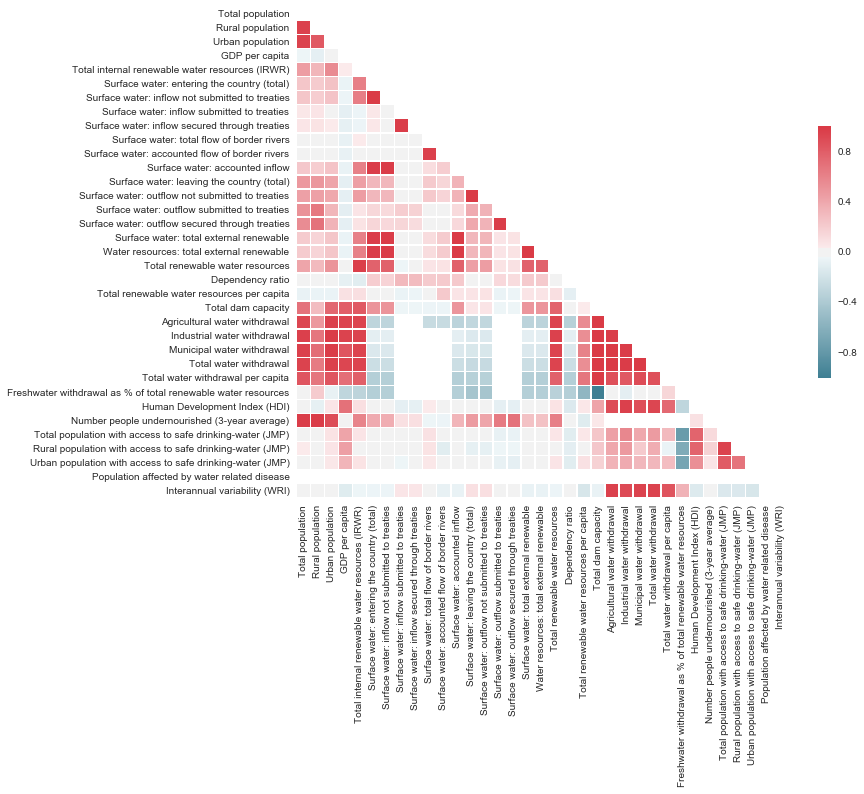

In [20]:
sns.set(style="white")


# Compute the correlation matrix
corr = dic['df2013'][dic['df2013'].columns.values[:-1]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

#### Проследим за зависимостью Agricultural, Industrial, Municipal water withdrawal % total withdrawal

In [23]:
df = df.dropna()
for x in ['Agricultural water withdrawal','Industrial water withdrawal',
          'Municipal water withdrawal']:
    for y in df.index:
        df.at[y, x] = df.at[y, x] / df.at[y,'Total water withdrawal']

In [24]:
df = df.drop('Total water withdrawal', 1)
df['GDP per capita'] = df['GDP per capita'].apply(np.log)

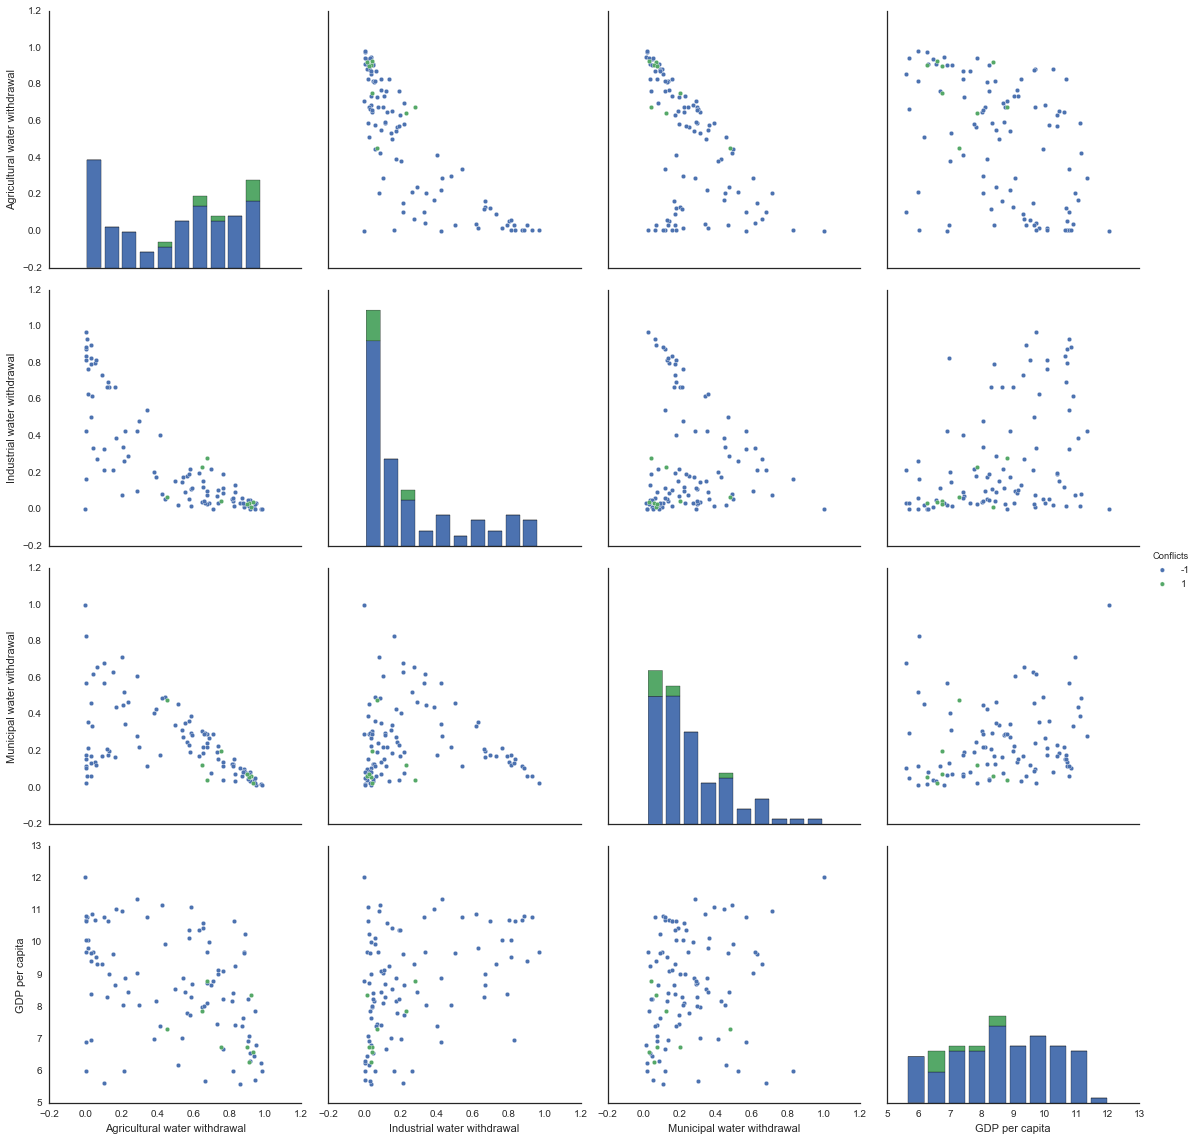

In [25]:
sns_plot = sns.pairplot(data = df, hue = "Conflicts", vars = ['Agricultural water withdrawal','Industrial water withdrawal',
          'Municipal water withdrawal','GDP per capita'], size=4, dropna=True)
fig = sns_plot
fig.savefig("output", format = 'png', dpi = 300)
plt.show()
plt.show()

#### Ввод признаков

Признак №1: Средний за 1990 - 2015 года объем доступных внутренних водных ресурсов на душу населения (население взято везде далее среднее за 1990 - 2015)

In [26]:
df = pd.DataFrame([])

In [27]:
population = 0
for y in dic['df2013'].index:
    count = 0
    for x in [1988 + x for x in range(0,28,5)]:
        ### Средняя численность населения за 1990 - 2015 в регионе
        if ~np.isnan(dic['df' + str(x)].at[y, 'Total population']):
            population += dic['df' + str(x)].at[y, 'Total population']
            count += 1
    population = population / count
    for z in ['Total internal renewable water resources (IRWR)']:
        if ~ np.isnan(dic['df2013'].at[y, z]):
            df.at[y, 'Total internal renewable water resources (IRWR) per capita (1990 - 2015)'] = dic['df2013'].at[y, z] / population * 1000000
    population = 0

Признак №2: Фактический объем водных ресурсов на душу населения, поступающих из-за границы, которые не подчиняется никаким специальным договорам, регулирующим объемы потребления этих водных ресурсов (как правило, это 50% всех возобновляемых объемов водных ресурсов из рек, протекающих и за границей) <br/> <br/>
Признак №3: Фактический объем водных ресурсов на душу населения, из протекающих по границе рекам, который доступен стране для потребления (как правило, это 50% всех возобновляемых объемов таких рек, если 2 страны)

In [28]:
population = 0
for y in dic['df2013'].index:
    count = 0
    for x in [1988 + x for x in range(0,28,5)]:
        ### Средняя численность населения за 1990 - 2015 в регионе
        if ~np.isnan(dic['df' + str(x)].at[y, 'Total population']):
            population += dic['df' + str(x)].at[y, 'Total population']
            count += 1
    population = population / count
    for z in ['Surface water: inflow not submitted to treaties', 'Surface water: accounted flow of border rivers',]:
        if ~ np.isnan(dic['df2013'].at[y, z]):
            df.at[y, z + ' per capita (1990 - 2015)'] = dic['df2013'].at[y, z] / population * 1000000
    population = 0

Признак №4: Фактический среднегодовой объем водных ресурсов на душу населения из внешних возобновляемых подземных источников, доступных стране

In [29]:
df_groundwater = pd.read_csv('groundwater.csv', sep = ',')

In [30]:
df_groundwater = df_groundwater[['\ufeff""', '2008-2012', 'Unnamed: 1']]

In [31]:
df_groundwater['\ufeff""'] = df_groundwater['\ufeff""'].replace('Côte d\'Ivoire','Cote d\'Ivoire')

In [32]:
population = 0
for y in df_groundwater['\ufeff""'].unique():
    if y in dic['df2013'].index:
        count = 0
        for x in [1988 + x for x in range(0,28,5)]:
            ### Средняя численность населения за 1990 - 2015 в регионе
            if ~np.isnan(dic['df' + str(x)].at[y, 'Total population']):
                population += dic['df' + str(x)].at[y, 'Total population']
                count += 1
        population = population / count
        for z in ['Groundwater produced internally (10^9 m3/year)',\
                  'Groundwater: entering the country (total) (10^9 m3/year)']:
            if len(df_groundwater[(df_groundwater['Unnamed: 1'] == z)\
                                & (df_groundwater['\ufeff""'] == y)]['2008-2012'].values) != 0:
                if z == 'Groundwater produced internally (10^9 m3/year)':
                    continue
                else:
                    df.at[y, 'Groundwater entering the country per capita (2013)'] =\
                    float(df_groundwater[(df_groundwater['Unnamed: 1'] == z)\
                                    & (df_groundwater['\ufeff""'] == y)]['2008-2012'].values[0])/population * 1000000
        population = 0

Признак №5: Interannual vulnerability

In [33]:
df['Interannual variability (WRI)'] = dic['df2013']['Interannual variability (WRI)']    

Признак №6: Dependency ratio

In [34]:
df['Dependency ratio'] = dic['df2013']['Dependency ratio']

Признак №7: Доля воды, использованная сельскохозяйственным сектором из общего объема потребленных водных ресурсов

In [35]:
### Ввод новой переменной - доля воды потребленной внутренней/внешней
for i in [1988 + x for x in range(0,28,5)]:
    for y in dic['df' + str(i)].index:
        for z in ['Agricultural water withdrawal', 'Industrial water withdrawal','Municipal water withdrawal']:
            if ~np.isnan(dic['df' + str(i)].at[y, z]):
                dic['df' + str(i)].at[y, z] = dic['df' + str(i)].at[y, z] / dic['df' + str(i)].at[y,'Total water withdrawal']

In [36]:
result1 = pd.Series([])
result = []
for i in df1['Area'].unique():
    for x in [1988 + x for x in range(0,28,5)]:
        if ~ np.isnan(dic['df' + str(x)].at[i, 'Agricultural water withdrawal']):
            result.append(dic['df' + str(x)].at[i, 'Agricultural water withdrawal'])
    result1[i] = np.array([result]).var()
    result = []

/Users/nichitagherman/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [37]:
# Описание метода: меньше 2 наблюдений - удаляем. остальные - оставляем, если Var > 0.005
result = []
result2 = pd.Series([])
for i in result1.index:
    for x in [1988 + x for x in range(0,28,5)]:
        y = dic['df' + str(x)].at[i, 'Agricultural water withdrawal']
        if np.isnan(y):
            continue
        else:
            result.append(dic['df' + str(x)].at[i, 'Agricultural water withdrawal'])
    if (np.array([result]).var() < 0.05) & (len(result) >= 2):
        result2[i] = np.array([result]).mean()
    result = []
result2

/Users/nichitagherman/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Albania                               0.601620
Algeria                               0.601401
Angola                                0.267859
Antigua and Barbuda                   0.170428
Argentina                             0.746127
Australia                             0.659748
Austria                               0.027018
Bahrain                               0.505146
Barbados                              0.676543
Belgium                               0.005037
Botswana                              0.445052
Brazil                                0.585059
Bulgaria                              0.188485
Burkina Faso                          0.635990
Cameroon                              0.556312
Canada                                0.091083
Central African Republic              0.005780
Chad                                  0.777890
China                                 0.750691
Colombia                              0.589079
Cote d'Ivoire                         0.486499
Cuba         

In [38]:
df['Agricultural water withdrawal'] = result2

Признак №8: Средняя за 1990 - 2013 доля населения, имевшая доступ к воде, прошедшей первичную обработку

In [39]:
# Отчет начинаем с 1988 - когда появляются данные
result = []
for y in dic['df2013'].index:
    for z in ['Total population with access to safe drinking-water (JMP)']:
        for i in [1988 + x for x in range(0,28,5)]:
            if ~ np.isnan(dic['df' + str(i)].at[y, z]):
                result.append(dic['df' + str(i)].at[y, z])
        if result:
            df.at[y,z + '(1990 - 2013)'] = np.array([result]).mean()/100
        result = []

Признак №9: ВВП на душу населения за 2013 год <br/> <br/>
Признак №10: Среднегодовые темпы прироста ВВП с 1990 - 2013 год

In [40]:
population = 0
result = []
for y in dic['df2013'].index:
    for x in [1988 + x for x in range(0,28,5)]:
        for z in ['GDP per capita']:
            if ~ np.isnan(dic['df' + str(x)].at[y, z]):
                result.append(dic['df' + str(x)].at[y, z])
    df.at[y, z + ' (1990 - 2015)'] = np.array([result]).mean()
    result = []

/Users/nichitagherman/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [41]:
result = []
def func1(y, z, k = 1988):
    if k == 2013:
        return np.nan
    if ~ np.isnan(dic['df' + str(k)].at[y, z]):
        return [k, dic['df' + str(k)].at[y, z]]
    else:
        k += 5
        return(func1(y, z, k))
def func2(y, z, k = 2013):
    if k == 1988:
        return np.nan
    if ~ np.isnan(dic['df' + str(k)].at[y, z]):
        return [k, dic['df' + str(k)].at[y, z]]
    else:
        k = k - 5
        return(func2(y, z, k))
for y in dic['df1988'].index:
    for z in ['GDP per capita']:
        result.append(func1(y, z))
        result.append(func2(y, z))
        if np.nan in result:
            df.at[y,'GDP per capita growth'] = np.nan
        else:  
            df.at[y,'GDP per capita growth'] = (result[1][1]/result[0][1])**(1/(result[1][0] - result[0][0])) - 1
        result = []

Признак №11: Средняя за 1990 - 2015 плотность населения

In [42]:
df_population_density = pd.read_csv('population_density.csv', sep = ',', encoding = "Windows-1251")

In [43]:
for i in range(0, df_population_density.shape[0], 2):
    row = df_population_density.values[i][0].split(",")
    result = []
    for x in row:
        try:
            float(x)
            num = float(x)
            if int(num) == num:
                continue
            else:
                result.append(num)
        except ValueError:
            continue
    if row[0] in df.index:
        df.at[row[0], 'population_density'] = np.array([result]).mean()
    elif row[0] == 'C“te d\'Ivoire':
        df.at['Cote d\'Ivoire', 'population_density'] = np.array([result]).mean() 

/Users/nichitagherman/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Признак № 12: Изменение общей вместимости дамб

In [44]:
df.at['Denmark', 'Total dam capacity growth'] = 0

In [45]:
population = 0
for y in dic['df2013'].index:
    for z in ['Total dam capacity']:
        if df1[(df1['Area'] == y) & (df1['Variable Name'] == z)]['Value'].shape[0] < 1:
            df.at[y,'Total dam capacity growth'] = np.nan
        else:
            result = df1[(df1['Area'] == y) & (df1['Variable Name'] == z)]['Value'].unique()
            if len(result) == 1:
                df.at[y, 'Total dam capacity growth'] = 0
            else:
                count = 0
                for x in [1988 + x for x in range(0,28,5)]:
                    ### Средняя численность населения за 1990 - 2015 в регионе
                    if ~np.isnan(dic['df' + str(x)].at[y, 'Total population']):
                        population += dic['df' + str(x)].at[y, 'Total population']
                        count += 1
                population = population / count
                df.at[y, 'Total dam capacity growth'] = (max(result) - min(result))/population
            result = []
            population = 0

#### Обработка пропусков в данных

In [48]:
def check(country, variable):
    return df1[(df1['Area'] == country) & (df1['Variable Name'] == variable)]

In [49]:
df.at['Austria', 'Agricultural water withdrawal'] = 0.2734

https://web.archive.org/web/20040909180844/http://earthtrends.wri.org/text/water-resources/country-profile-14.html

In [50]:
df.at['Bangladesh', 'Agricultural water withdrawal'] = 0.8782

https://www.cia.gov/library/publications/the-world-factbook/fields/2202.html

http://www.tradingeconomics.com/chile/annual-freshwater-withdrawals-total-percent-of-internal-resources-wb-data.html

In [52]:
df.at['Chile', 'Agricultural water withdrawal'] = 0.7878

In [53]:
df.at['China', 'Agricultural water withdrawal'] = 0.7507

http://postconflict.unep.ch/publications/UNEP_DRC_water.pdf P 20 + прогноз на 2025

In [55]:
df.at['Denmark', 'Agricultural water withdrawal'] = 0.2347

In [56]:
df.at['Niger', 'Agricultural water withdrawal'] = 0.6674

https://en.wikipedia.org/wiki/Water_resources_management_in_Peru 

In [57]:
df.at['Peru', 'Agricultural water withdrawal'] = 0.84365

In [59]:
df.at['United Kingdom', 'Agricultural water withdrawal'] = 0.09256

https://www.cia.gov/library/publications/the-world-factbook/fields/2202.html

In [60]:
df.at['Ethiopia', 'Agricultural water withdrawal'] = 0.89815

In [61]:
df.at['Armenia', 'Agricultural water withdrawal'] = 0.6608

https://www.cia.gov/library/publications/the-world-factbook/fields/2202.html

In [62]:
df.at['Latvia', 'Agricultural water withdrawal'] = 0.1277

In [63]:
df.at['Lithuania', 'Agricultural water withdrawal'] = 0.02918

In [64]:
indexes = df.dropna(subset = ['Agricultural water withdrawal']).index.unique()

In [65]:
result1 = pd.Series([])
result = []
for i in indexes:
    for x in [1988 + x for x in range(0,28,5)]:
        if ~ np.isnan(dic['df' + str(x)].at[i, 'Total water withdrawal']):
            result.append(dic['df' + str(x)].at[i, 'Total water withdrawal'])
    result1[i] = result
    result = []

In [115]:
df.at['Israel', 'Total dam capacity growth'] = 0
df.at['Syrian Arab Republic', 'GDP per capita (1990 - 2015)'] =  3687.0
df.at['Syrian Arab Republic', 'Conflicts'] = 1

#### Добавление признаков из других источников

Признак №13: Индекс коррупции

In [67]:
df_corruption = pd.read_csv("corruption.csv", sep = ";", encoding = 'Windows-1251')

In [68]:
df_corruption

,CPI2015,Country
0,91,Denmark
1,90,Finland
2,89,Sweden
3,88,New Zealand
4,87,Netherlands
5,87,Norway
6,86,Switzerland
7,85,Singapore
8,83,Canada
9,81,Germany


In [69]:
df_merge = pd.Series(df_corruption['CPI2015'].values, index = df_corruption['Country'])

In [70]:
df['Corruption (CPI 2015)'] = df_merge

Признак №14: Индекс кооперации

In [71]:
df_treaties = pd.read_csv('treaties.csv', sep = ";", encoding = 'Windows-1251', low_memory = False)

In [72]:
df_treaties = df_treaties[['TREATY_METADATA_DocID', 'Country_Name', 'PRIMARY_COUNTRY_CONTINENT', 'Basin_Name', ]]

In [73]:
countries_treaties = pd.DataFrame([], columns = ['Country_Name', 'Basin_Name', 'TREATY_METADATA_DocID'])
count = 0
result = []
for i in df_treaties['Country_Name'].unique():
    for x in df_treaties[df_treaties['Country_Name'] == i]['Basin_Name'].unique():
        if x != 'General' and x != 'Unknown':
            result.append(x)
    if i == 'European Union' or i == 'Yugoslavia (Former)' or i == 'European Economic Community'\
    or i == 'Macau' or i == 'Unknown' or i == 'Union of Soviet Socialist Republics'\
    or i == 'Myanmar (Burma)' or i == 'European Community'\
    or i == 'Netherlands Antilles' or i == 'Cape Verde':
        result = []
        continue
    elif i == 'Bolivia':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                countries_treaties.at[count, 'Basin_Name'] = y
                countries_treaties.at[count, 'Country_Name'] = 'Bolivia (Plurinational State of)'
                countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                count += 1
        result = []
    elif i == 'Congo, Democratic Republic of (Kinshasa)':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Democratic Republic of the Congo'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []
    elif i == 'Congo, Republic of the (Brazzaville)':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Congo'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []
    elif i == 'Iran':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Iran (Islamic Republic of)'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []
    elif i == 'Tanzania, United Republic of':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'United Republic of Tanzania'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []
    elif i == 'Russia':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Russian Federation'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []
    elif i == 'Cambodia (Kampuchea)':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Cambodia'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []
    elif i == 'Byelarus':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Belarus'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []
    elif i == 'South Korea':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Republic of Korea'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []
    elif i == 'Korea, Democratic People\'s Republic of (North)':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Democratic People\'s Republic of Korea'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []
    elif i == 'Vietnam':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Viet Nam'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []
    elif i == 'Syria':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Syrian Arab Republic'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = [] 
    elif i == 'Moldova':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Republic of Moldova'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []
    elif i == 'Venezuela':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Venezuela (Bolivarian Republic of)'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []
    elif i == 'Laos, People\'s Democratic Republic of':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Lao People\'s Democratic Republic'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = [] 
    elif i == 'Ivory Coast':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Cote d\'Ivoire'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = [] 
    elif i == 'Gambia, The':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'Gambia'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []
    elif i == 'Macedonia':
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = 'The former Yugoslav Republic of Macedonia'
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []   
    else:
        for y in result:
            for z in df_treaties[(df_treaties['Country_Name'] == i) & (df_treaties['Basin_Name'] == y)]['TREATY_METADATA_DocID'].unique():
                if z != 'Groundwater':
                    countries_treaties.at[count, 'Basin_Name'] = y
                    countries_treaties.at[count, 'Country_Name'] = i
                    countries_treaties.at[count, 'TREATY_METADATA_DocID'] = z
                    count += 1
        result = []

In [74]:
result1 = 0
count = 0
sum_dependancy = 0
num_countries = 0
N = 0
result2 = 0
number_of_treaties = pd.DataFrame([], columns = ['Country Name', 'Number of treaties/Number of countries'])
for i in countries_treaties['Country_Name'].unique():
    if 1 > 0:
        for x in countries_treaties[countries_treaties['Country_Name'] == i]['Basin_Name'].unique():
            N += countries_treaties[countries_treaties['Basin_Name'] == x]['Country_Name'].unique().shape[0]
        for x in countries_treaties[countries_treaties['Country_Name'] == i]['Basin_Name'].unique():
            if x != 'Groundwater': 
                result1 += countries_treaties[countries_treaties['Basin_Name'] == x]['TREATY_METADATA_DocID'].unique().shape[0]
                for y in countries_treaties[countries_treaties['Basin_Name'] == x]['Country_Name'].unique():
                    if ~ np.isnan(dic['df2013'].at[y, 'Dependency ratio']):
                        sum_dependancy += abs(dic['df2013'].at[y, 'Dependency ratio'])
                    else:
                        N = N - 1
                result2 += sum_dependancy/(N * np.sqrt(result1))
                if np.isnan(dic['df2013'].at[y, 'Dependency ratio']):
                    N = N + 1
                result1 = 0
                sum_dependancy = 0
        number_of_treaties.at[count, 'Number of treaties/Number of countries'] = result2
        number_of_treaties.at[count, 'Country Name'] = i
        count += 1
        N = 0
        result2 = 0

In [75]:
for i in df.index:
    if i not in number_of_treaties['Country Name'].unique():
        number_of_treaties.at[count, 'Number of treaties/Number of countries'] = dic['df2013'].at[i, 'Dependency ratio']
        number_of_treaties.at[count, 'Country Name'] = i
        count += 1

In [76]:
result = pd.Series(number_of_treaties['Number of treaties/Number of countries'].values, index = number_of_treaties['Country Name'].values)

In [77]:
result

Greece                                       11.5379
Spain                                        13.4299
France                                       7.58094
India                                        27.2846
Pakistan                                     16.3369
Egypt                                        8.08528
Sudan                                        8.08528
Switzerland                                  6.27707
Nepal                                        6.89694
Czech Republic                               12.1314
Poland                                       13.8593
Slovakia                                     12.1314
Italy                                        6.15674
China                                        7.21186
Democratic People's Republic of Korea        4.02958
Germany                                      9.01404
Netherlands                                  11.1676
Mexico                                       8.88475
United States of America                     3

In [78]:
result

Greece                                       11.5379
Spain                                        13.4299
France                                       7.58094
India                                        27.2846
Pakistan                                     16.3369
Egypt                                        8.08528
Sudan                                        8.08528
Switzerland                                  6.27707
Nepal                                        6.89694
Czech Republic                               12.1314
Poland                                       13.8593
Slovakia                                     12.1314
Italy                                        6.15674
China                                        7.21186
Democratic People's Republic of Korea        4.02958
Germany                                      9.01404
Netherlands                                  11.1676
Mexico                                       8.88475
United States of America                     3

In [79]:
df['Cooperation Index'] = result 

Признак №15: Индекс загрязненности

In [80]:
df_pollution = pd.read_csv('pollution.csv', sep = ";")

In [81]:
for i in df_pollution.values[:, 0]:
    df.at[i, 'Pollution_index (2011)'] = df_pollution[df_pollution['Afghanistan'] == i]['Unnamed: 1'].values[0]

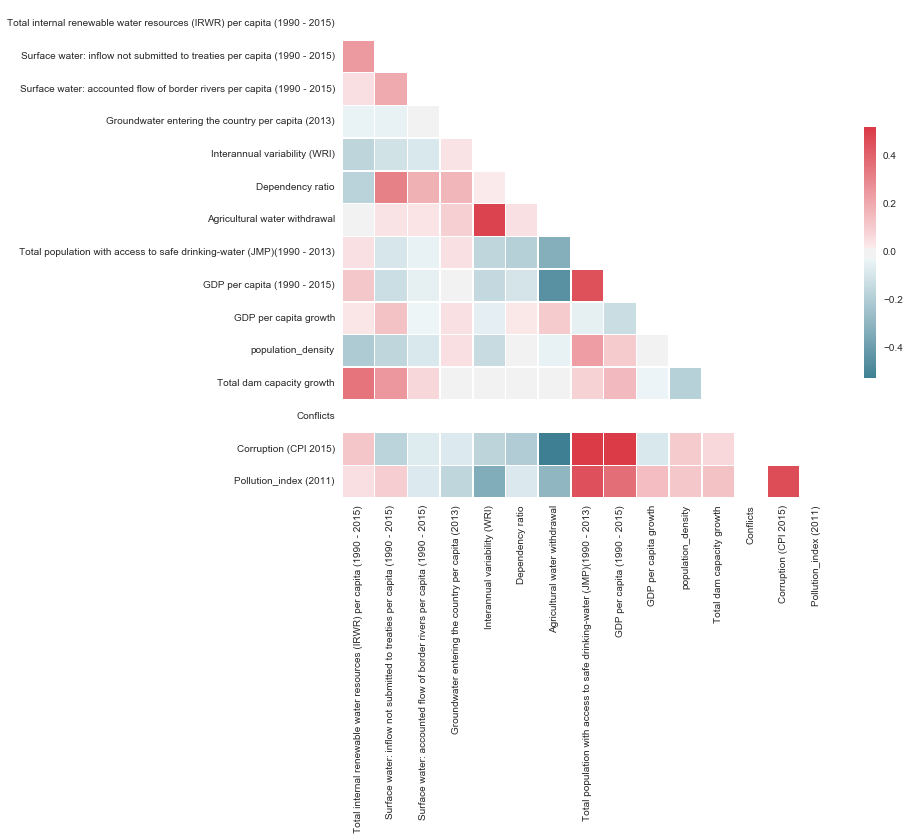

In [82]:
sns.set(style="white")


# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

Источники данных для Судана: <br/> <br/>
https://knoema.com/atlas/Sudan/topics/Water/Water-Withdrawal/Agricultural-water-withdrawal-percent

In [83]:
df.at['Sudan', 'Agricultural water withdrawal'] = 0.95

Добавление целевой переменной

In [118]:
dr = df['Conflicts']
df = df.drop('Conflicts', axis = 1)
df['Conflicts'] = dr

In [119]:
df['Conflicts'] = dic['df2013']['Conflicts'].astype(int)
df['Cooperation Index'] = df['Cooperation Index'].astype(float)

In [120]:
df.describe()

,Total internal renewable water resources (IRWR) per capita (1990 - 2015),Surface water: inflow not submitted to treaties per capita (1990 - 2015),Surface water: accounted flow of border rivers per capita (1990 - 2015),Groundwater entering the country per capita (2013),Interannual variability (WRI),Dependency ratio,Agricultural water withdrawal,Total population with access to safe drinking-water (JMP)(1990 - 2013),GDP per capita (1990 - 2015),GDP per capita growth,population_density,Total dam capacity growth,Corruption (CPI 2015),Cooperation Index,Pollution_index (2011),Conflicts
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,20499.843332,2274.329607,721.343083,8.123528,1.874757,27.888587,0.569713,0.844906,11104.876149,0.050447,99.984895,0.000314,43.417476,11.218712,68.937767,-0.766990
std,67330.137974,5215.550238,3716.517817,64.658114,0.890992,32.309178,0.318362,0.172179,15732.448683,0.025573,129.556826,0.000911,21.174126,10.791722,16.213127,0.644796
min,24.034182,0.000000,0.000000,0.000000,0.600000,0.000000,0.003117,0.369000,243.183333,-0.018775,1.639333,0.000000,12.000000,0.000000,34.000000,-1.000000
25%,951.212413,0.000000,0.000000,0.000000,1.200000,1.166500,0.276147,0.794917,1258.816667,0.031192,20.701000,0.000000,28.000000,5.546196,57.540000,-1.000000
50%,2695.475452,180.255471,0.000000,0.000000,1.600000,11.070000,0.659748,0.897833,3707.500000,0.048822,57.761667,0.000025,36.000000,10.786667,69.740000,-1.000000
75%,9343.948012,1997.421357,8.522698,0.000000,2.400000,50.910000,0.840892,0.990417,12817.333333,0.062767,110.637500,0.000179,56.000000,14.490738,80.630000,-1.000000
max,573742.828215,40308.133286,34949.566448,646.823513,4.900000,97.000000,0.978027,1.000000,75146.666667,0.129791,871.250000,0.005594,90.000000,76.600000,99.410000,1.000000


#### Анализ признаков

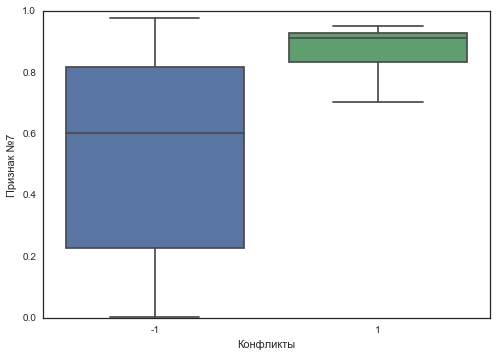

In [121]:
g = sns.boxplot(x="Conflicts", y='Agricultural water withdrawal', data=df)
g.set(xlabel='Конфликты', ylabel='Признак №7')
g.figure.savefig('Priznak7.eps', format = 'eps', dpi = 1000)
plt.show()

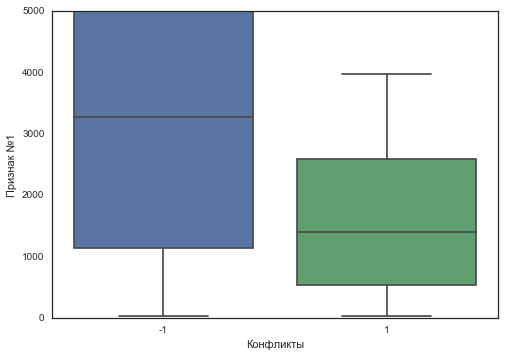

In [122]:
g = sns.boxplot(x="Conflicts", y='Total internal renewable water resources (IRWR) per capita (1990 - 2015)', data=df)
g.set(xlabel='Конфликты', ylabel='Признак №1')
g.set(ylim = (0, 5000))
g.figure.savefig('Priznak1.eps', format = 'eps', dpi = 1000)
plt.show()

In [123]:
df = df.dropna()

In [124]:
for i in countries.index:
    if i not in df.index:
        print(i)

Somalia
Occupied Palestinian Territory
Afghanistan


In [130]:
df.at['Syrian Arab Republic', 'Conflicts'] = 1

## Обучение классификаторов

In [132]:
from sklearn.preprocessing import scale
X = df[df.columns.values[:-1]].values
y = df[df.columns.values[-1]].values
X = scale(X)
y = y.astype(int)

In [133]:
from sklearn.cross_validation import KFold
kf = KFold(X.shape[0], n_folds = 5, shuffle=True, random_state = 243)

In [134]:
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import grid_search

#### Случай №1: random_state = 43

In [159]:
def classifier(y, X, clf, grid, title, allow_max = True):
    cv = KFold(X.shape[0], n_folds = 5, shuffle=True, random_state = 43)
    
    gs1 = grid_search.GridSearchCV(clf, grid, scoring='recall', cv=cv)
    gs1.fit(X, y)
    result1 = []
    for i in range(len(gs1.grid_scores_)):
        result1.append(gs1.grid_scores_[i][2].mean())
    
    gs2 = grid_search.GridSearchCV(clf, grid, scoring='accuracy', cv=cv)
    gs2.fit(X, y)
    result2 = []
    for i in range(len(gs2.grid_scores_)):
        result2.append(gs2.grid_scores_[i][2].mean())

    plt.figure(figsize = (8, 6))
    plt.plot(grid[list(grid.keys())[0]], result1, c = 'b', label = 'recall')
    plt.plot(grid[list(grid.keys())[0]], result2, c = 'r', label = 'accuracy')
    plt.title(title)
    plt.xlabel(list(grid.keys())[0])
    plt.ylabel('accuracy or recall')
    plt.legend()
    plt.show()
    print('Оптимальное значение метрики качества %s: %.2f для %s = %.2f' % ('recall',max(result1), list(grid.keys())[0], grid[list(grid.keys())[0]][result1.index(max(result1))]))
    print('Оптимальное значение метрики качества %s: %.2f для %s = %.2f' % ('accuracy',max(result2), list(grid.keys())[0], grid[list(grid.keys())[0]][result2.index(max(result2))]))
    return [result1, result2]

In [160]:
def weights (y, X, clf):
    clf.fit(X, y)
    return clf.coef_

#### Логистическая регрессия

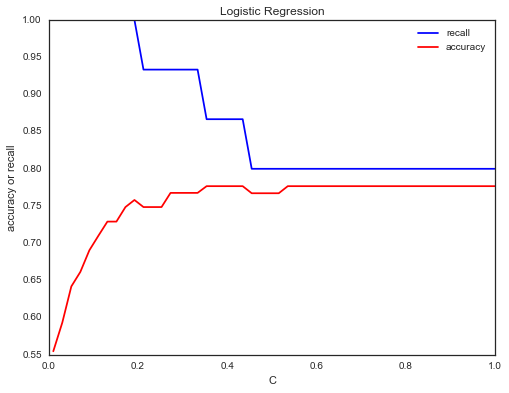

Оптимальное значение метрики качества recall: 1.00 для C = 0.01
Оптимальное значение метрики качества accuracy: 0.78 для C = 0.35


In [161]:
result = classifier(y, X, LogisticRegression(class_weight = 'balanced'), {'C': np.linspace(0.01, 1, 50)}, 'Logistic Regression')

Оптимальное значение гиперпараметра C для логистической регрессии: 0.15

In [164]:
count = 0
for x in np.linspace(0.01, 1, 50):
    count += 1
    if abs(x - 0.15) < 0.01:
        print(result[0][count], result[1][count])

1.0 0.748571428571


In [166]:
weights(y, X, LogisticRegression(penalty = 'l2', C = 0.15, class_weight = 'balanced'))

array([[-0.1065413 , -0.43935828, -0.18800085,  0.22628678,  0.00359545,
         0.29676991,  0.83726699, -0.06368237, -0.20914591,  0.30206847,
        -0.17140048, -0.16266699, -0.43961637, -0.02503293,  0.30850138]])

#### SVC

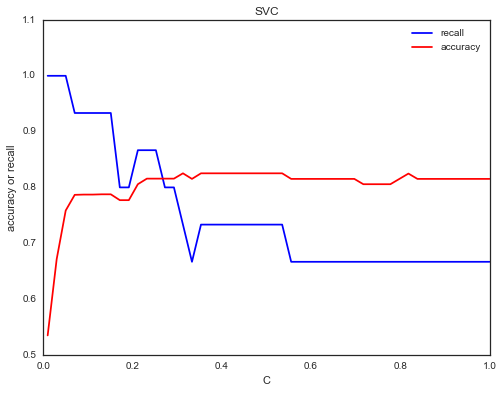

Оптимальное значение метрики качества recall: 1.00 для C = 0.01
Оптимальное значение метрики качества accuracy: 0.83 для C = 0.31


In [167]:
result = classifier(y, X,\
                    SVC(kernel = 'linear',class_weight = 'balanced', random_state = 243), {'C': np.linspace(0.01, 1, 50)}, 'SVC')

Оптимальное значение гиперпараметров для метода опорных векторов: C = 0.1, ядро: линейное

In [171]:
count = 0
for x in np.linspace(0.01, 1, 50):
    count += 1
    if abs(x - 0.1) < 0.01:
        print(result[0][count], result[1][count])

0.933333333333 0.787142857143


In [172]:
weights(y, X, SVC(kernel = 'linear',C = 0.1, class_weight = 'balanced'))

array([[-0.17646635, -0.4852796 , -0.21649361,  0.01093001,  0.12333153,
         0.13251067,  0.91919777, -0.08221554, -0.24073664,  0.33539047,
        -0.33018385, -0.28469552, -0.5235223 ,  0.39197394,  0.36311383]])

#### Решающие деревья

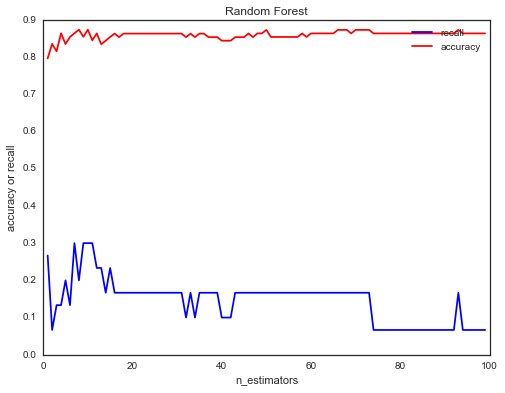

Оптимальное значение метрики качества recall: 0.30 для n_estimators = 7.00
Оптимальное значение метрики качества accuracy: 0.87 для n_estimators = 8.00


In [173]:
result = classifier(y, X,\
                    RandomForestClassifier(random_state = 243), {'n_estimators': list(range(1, 100))}, 'Random Forest')

In [174]:
count = 0
for x in range(1, 50):
    count += 1
    if abs(x - 10) == 0:
        print(result[0][count], result[1][count])

0.3 0.845238095238


Оптимальное количество деревьев: 10

In [177]:
clf = RandomForestClassifier(n_estimators = 10, random_state = 243)
clf.fit(X, y)
clf.feature_importances_

array([ 0.05880905,  0.01551229,  0.00503053,  0.03865684,  0.03031271,
        0.07365887,  0.18308573,  0.04519206,  0.09407387,  0.13835464,
        0.05028228,  0.03365163,  0.11788132,  0.06631281,  0.04918536])

#### Случай №2: random_state = 42

In [180]:
def classifier(y, X, clf, grid, title, allow_max = True):
    cv = KFold(X.shape[0], n_folds = 5, shuffle=True, random_state = 42)
    
    gs1 = grid_search.GridSearchCV(clf, grid, scoring='recall', cv=cv)
    gs1.fit(X, y)
    result1 = []
    for i in range(len(gs1.grid_scores_)):
        result1.append(gs1.grid_scores_[i][2].mean())
    
    gs2 = grid_search.GridSearchCV(clf, grid, scoring='accuracy', cv=cv)
    gs2.fit(X, y)
    result2 = []
    for i in range(len(gs2.grid_scores_)):
        result2.append(gs2.grid_scores_[i][2].mean())

    plt.figure(figsize = (8, 6))
    plt.plot(grid[list(grid.keys())[0]], result1, c = 'b', label = 'recall')
    plt.plot(grid[list(grid.keys())[0]], result2, c = 'r', label = 'accuracy')
    plt.title(title)
    plt.xlabel(list(grid.keys())[0])
    plt.ylabel('accuracy or recall')
    plt.legend()
    plt.show()
    print('Оптимальное значение метрики качества %s: %.2f для %s = %.2f' % ('recall',max(result1), list(grid.keys())[0], grid[list(grid.keys())[0]][result1.index(max(result1))]))
    print('Оптимальное значение метрики качества %s: %.2f для %s = %.2f' % ('accuracy',max(result2), list(grid.keys())[0], grid[list(grid.keys())[0]][result2.index(max(result2))]))
    return [result1, result2]

#### Логистическая регрессия

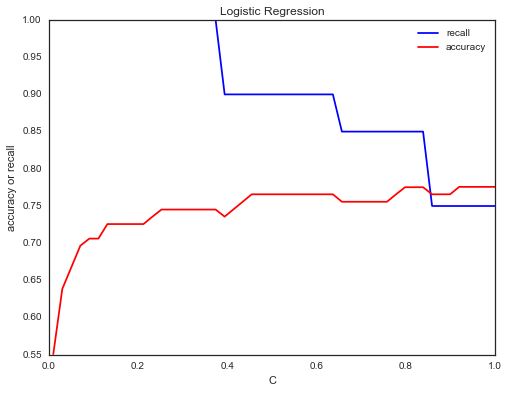

Оптимальное значение метрики качества recall: 1.00 для C = 0.01
Оптимальное значение метрики качества accuracy: 0.78 для C = 0.92


In [221]:
result = classifier(y, X, LogisticRegression(class_weight = 'balanced'), {'C': np.linspace(0.01, 1, 50)}, 'Logistic Regression')

In [227]:
count = 0
for x in np.linspace(0.01, 1, 50):
    count += 1
    if abs(x - 0.35) < 0.009:
        print(result[0][count], result[1][count])

1.0 0.745238095238


In [224]:
weights(y, X, LogisticRegression(penalty = 'l2', C = 0.4, class_weight = 'balanced'))

array([[-0.151261  , -0.66621148, -0.30022687,  0.28981603, -0.02535699,
         0.38544823,  1.23414143, -0.04870221, -0.26672076,  0.41451783,
        -0.30447697, -0.25822281, -0.61685691, -0.03563583,  0.51278251]])

#### SVC

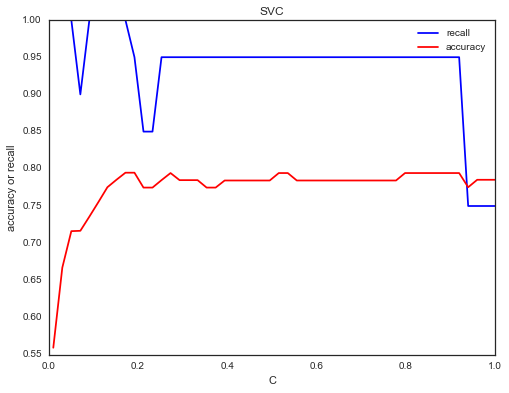

Оптимальное значение метрики качества recall: 1.00 для C = 0.01
Оптимальное значение метрики качества accuracy: 0.79 для C = 0.17


In [184]:
result = classifier(y, X,\
                    SVC(kernel = 'linear',class_weight = 'balanced', random_state = 243), {'C': np.linspace(0.01, 1, 50)}, 'SVC')

In [185]:
count = 0
for x in np.linspace(0.01, 1, 50):
    count += 1
    if abs(x - 0.5) < 0.009:
        print(result[0][count], result[1][count])

0.95 0.794285714286


In [186]:
weights(y, X, SVC(kernel = 'linear',C = 0.5, class_weight = 'balanced'))

array([[-0.65042643, -0.49630917, -0.71607174,  0.0332765 ,  0.16014206,
         0.13200382,  1.51104793, -0.06995366, -0.34801588,  0.567025  ,
        -0.43962648, -0.35518897, -0.7505604 ,  0.2849906 ,  0.62222888]])

#### Случайный лес

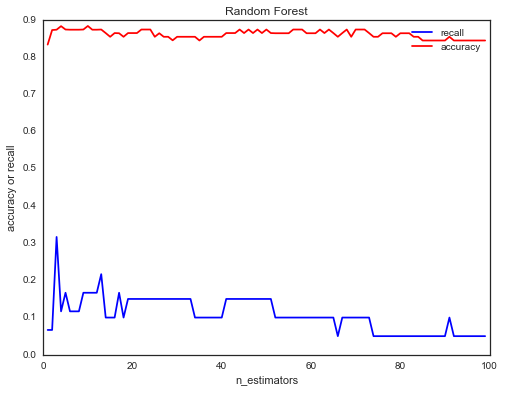

Оптимальное значение метрики качества recall: 0.32 для n_estimators = 3.00
Оптимальное значение метрики качества accuracy: 0.88 для n_estimators = 10.00


In [189]:
result = classifier(y, X,\
                    RandomForestClassifier(random_state = 243), {'n_estimators': list(range(1, 100))}, 'Random Forest')

In [190]:
clf = RandomForestClassifier(n_estimators = 2, random_state = 243)
clf.fit(X, y)
clf.feature_importances_

array([ 0.09217497,  0.        ,  0.        ,  0.        ,  0.03288633,
        0.02466475,  0.17172197,  0.08736584,  0.141217  ,  0.02466475,
        0.02466475,  0.        ,  0.12493901,  0.15707552,  0.1186251 ])

#### L-1 регуляризация + логистическая регрессия

Оптимальное значение C: 0.4

Random_states: 43, 88, 323

In [273]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 323)

In [274]:
model = LogisticRegression(penalty = 'l1', C = 0.4, class_weight = 'balanced')
model.fit(X_train, y_train)
model.coef_

array([[ 0.        , -0.53723655, -0.01398672,  0.14523719,  0.        ,
         0.36721262,  1.31146346,  0.        ,  0.        ,  0.22107646,
         0.        ,  0.        , -0.30869536,  0.        ,  0.10627712]])

In [275]:
from sklearn.metrics import recall_score
recall_score(y_test, model.predict(X_test))

1.0

In [276]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, model.predict(X_test))

0.76190476190476186

### Построение предсказаний

Отберем признаки, относительно которых мы рассматриваем расстояние

In [418]:
columns = []
for i in [1, 5, 6, 9, 12]:
    columns.append(df.columns.values[i])

In [419]:
indexes = []
count = 0
for i in df.index:
    if df.at[i, 'Conflicts'] == 1:
        indexes.append(count)
    count += 1

In [420]:
X = df[columns].values
X = scale(X)

In [421]:
from sklearn.neighbors import KDTree
tree = KDTree(X)
result = [[] for x in range(13)]
count = 0
for i in indexes:
    dist, ind = tree.query(X[i], k=4)
    for k in ind[0][1:]:
        result[count].append(k)
    count += 1

/Users/nichitagherman/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nichitagherman/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nichitagherman/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if i

In [422]:
result_countries = pd.Series([])
count = 0
for k in result:
    for i in k:
        if i not in indexes:
            result_countries[count] = i
            count += 1

In [434]:
itog = result_countries.value_counts()[:7].index

In [435]:
for i in itog:
    print(df.index[i])

Haiti
Nigeria
Armenia
Zambia
Mauritania
Eritrea
Indonesia


In [436]:
df.loc['Eritrea', :]

Total internal renewable water resources (IRWR) per capita (1990 - 2015)    648.869114
Surface water: inflow not submitted to treaties per capita (1990 - 2015)    162.217278
Surface water: accounted flow of border rivers per capita (1990 - 2015)     884.084168
Groundwater entering the country per capita (2013)                            0.000000
Interannual variability (WRI)                                                 4.300000
Dependency ratio                                                             61.720000
Agricultural water withdrawal                                                 0.823258
Total population with access to safe drinking-water (JMP)(1990 - 2013)        0.543200
GDP per capita (1990 - 2015)                                                414.400000
GDP per capita growth                                                         0.064725
population_density                                                           36.696000
Total dam capacity growth                  

In [391]:
df.loc['Zambia', :]

Total internal renewable water resources (IRWR) per capita (1990 - 2015)    6572.064628
Surface water: inflow not submitted to treaties per capita (1990 - 2015)    2015.870198
Surface water: accounted flow of border rivers per capita (1990 - 2015)        0.000000
Groundwater entering the country per capita (2013)                             0.000000
Interannual variability (WRI)                                                  2.100000
Dependency ratio                                                              23.470000
Agricultural water withdrawal                                                  0.757283
Total population with access to safe drinking-water (JMP)(1990 - 2013)         0.572833
GDP per capita (1990 - 2015)                                                 941.383333
GDP per capita growth                                                          0.062011
population_density                                                            16.215000
Total dam capacity growth       

In [437]:
df.loc['Haiti', :]

Total internal renewable water resources (IRWR) per capita (1990 - 2015)    1422.091053
Surface water: inflow not submitted to treaties per capita (1990 - 2015)     110.947150
Surface water: accounted flow of border rivers per capita (1990 - 2015)        0.000000
Groundwater entering the country per capita (2013)                             0.000000
Interannual variability (WRI)                                                  2.400000
Dependency ratio                                                               7.237000
Agricultural water withdrawal                                                  0.895695
Total population with access to safe drinking-water (JMP)(1990 - 2013)         0.602833
GDP per capita (1990 - 2015)                                                 551.066667
GDP per capita growth                                                          0.039940
population_density                                                           318.420000
Total dam capacity growth       

In [438]:
df.loc['Nigeria', :]

Total internal renewable water resources (IRWR) per capita (1990 - 2015)    1575.931743
Surface water: inflow not submitted to treaties per capita (1990 - 2015)     464.935519
Surface water: accounted flow of border rivers per capita (1990 - 2015)        0.000000
Groundwater entering the country per capita (2013)                             0.000000
Interannual variability (WRI)                                                  1.200000
Dependency ratio                                                              22.780000
Agricultural water withdrawal                                                  0.535981
Total population with access to safe drinking-water (JMP)(1990 - 2013)         0.565000
GDP per capita (1990 - 2015)                                                1342.333333
GDP per capita growth                                                          0.099536
population_density                                                           151.800000
Total dam capacity growth       

In [440]:
df.loc['Indonesia', :]

Total internal renewable water resources (IRWR) per capita (1990 - 2015)    9000.775698
Surface water: inflow not submitted to treaties per capita (1990 - 2015)       0.000000
Surface water: accounted flow of border rivers per capita (1990 - 2015)        0.000000
Groundwater entering the country per capita (2013)                             0.000000
Interannual variability (WRI)                                                  1.100000
Dependency ratio                                                               0.000000
Agricultural water withdrawal                                                  0.875054
Total population with access to safe drinking-water (JMP)(1990 - 2013)         0.802667
GDP per capita (1990 - 2015)                                                1953.333333
GDP per capita growth                                                          0.063522
population_density                                                           117.410000
Total dam capacity growth       

In [442]:
df1[(df1['Area'] == 'Indonesia') & (df1['Variable Name'] == 'GDP per capita')]

,Area,Variable Name,Year,Value,Conflicts
581,Indonesia,GDP per capita,1982,613.0,-1
4319,Indonesia,GDP per capita,1987,442.1,-1
8304,Indonesia,GDP per capita,1992,740.3,-1
13396,Indonesia,GDP per capita,1997,1065.0,-1
18579,Indonesia,GDP per capita,2002,901.7,-1
24319,Indonesia,GDP per capita,2007,1860.0,-1
29801,Indonesia,GDP per capita,2012,3701.0,-1
35200,Indonesia,GDP per capita,2014,3452.0,-1


In [282]:
from sklearn.neighbors import KNeighborsClassifier

## Расчеты

#### Ближний Восток

#### (1)

In [50]:
countries = ['Azerbaijan', 'Armenia', 'Bahrain', 'Georgia', 'Israel', 'Iraq', 'Iran (Islamic Republic of)',\
             'Yemen', 'Jordan', 'Qatar', 'Cyprus', 'Kuwait', 'Lebanon', 'United Arab Emirates',\
             'Oman', 'Occupied Palestinian Territory', 'Saudi Arabia', 'Syrian Arab Republic', 'Turkey']

In [51]:
dic['df2013'].loc[countries, :]['Total population'].sum()/dic['df2013']['Total population'].sum()

0.04579257723070998

In [52]:
dic['df2013'].loc[countries, :]['Total renewable water resources'].sum()/dic['df2013']['Total renewable water resources'].sum()

0.010524967731936369

#### (2) - с поправкой на изменение численности населения Израиля с 2010 по 2013 год (в Stategic Foresight Group 2010 их 7.3 млн, а в наших данных - 8 млн) + (6)

In [53]:
dic['df2013'].loc[countries, :]['Total population']

Azerbaijan                         9754.0
Armenia                            3018.0
Bahrain                            1377.0
Georgia                            4000.0
Israel                             8064.0
Iraq                              36423.0
Iran (Islamic Republic of)        79109.0
Yemen                             26832.0
Jordan                             7595.0
Qatar                              2235.0
Cyprus                             1165.0
Kuwait                             3892.0
Lebanon                            5851.0
United Arab Emirates               9157.0
Oman                               4491.0
Occupied Palestinian Territory     4668.0
Saudi Arabia                      31540.0
Syrian Arab Republic              18502.0
Turkey                            78666.0
Name: Total population, dtype: float64

In [54]:
dic['df2013'].loc[countries, :]['Total renewable water resources per capita']

Azerbaijan                         3555.000
Armenia                            2574.000
Bahrain                              84.240
Georgia                           15832.000
Israel                              220.700
Iraq                               2467.000
Iran (Islamic Republic of)         1732.000
Yemen                                78.260
Jordan                              123.400
Qatar                                25.950
Cyprus                              669.500
Kuwait                                5.139
Lebanon                             769.600
United Arab Emirates                 16.380
Oman                                311.700
Occupied Palestinian Territory      179.300
Saudi Arabia                         76.090
Syrian Arab Republic                908.000
Turkey                             2690.000
Name: Total renewable water resources per capita, dtype: float64

#### (3)

In [55]:
df.loc[countries, :]['Agricultural water withdrawal'].dropna().mean()

0.7569184614603617

#### (4)

In [81]:
stats.pearsonr((dic['df2003'][['Agricultural water withdrawal', \
                               'Total water withdrawal per capita']]).dropna()['Agricultural water withdrawal'],\
              (dic['df2003'][['Agricultural water withdrawal',\
                              'Total water withdrawal per capita']]).dropna()['Total water withdrawal per capita'])

(0.27803729577410857, 0.014351394310129393)

#### (5)

In [93]:
dic['df2013']['Interannual variability (WRI)']

Afghanistan                                  2.5
Albania                                      1.2
Algeria                                      2.3
Andorra                                      1.5
Angola                                       2.5
Antigua and Barbuda                          NaN
Argentina                                    2.4
Australia                                    3.2
Austria                                      0.9
Bahamas                                      NaN
Bahrain                                      3.1
Bangladesh                                   0.7
Barbados                                     NaN
Belgium                                      1.0
Belize                                       1.1
Benin                                        1.2
Bhutan                                       0.6
Bolivia (Plurinational State of)             2.5
Botswana                                     3.8
Brazil                                       1.7
Brunei Darussalam   

### Африка

#### (7)

In [142]:
countries2 = ['Rwanda', 'Burundi', 'United Republic of Tanzania', 'Kenya',\
             'Democratic Republic of the Congo', 'Uganda',\
             'Eritrea', 'Ethiopia', 'South Sudan',\
             'Sudan', 'Egypt', 'Somalia']

In [143]:
data = pd.DataFrame(np.array([dic['df2013'].loc[countries2, :]['Total renewable water resources per capita'].values, countries2]).T, columns = ['Среднегодовой объем располагаемых водных ресурсов на душу населения', 'Страны'])

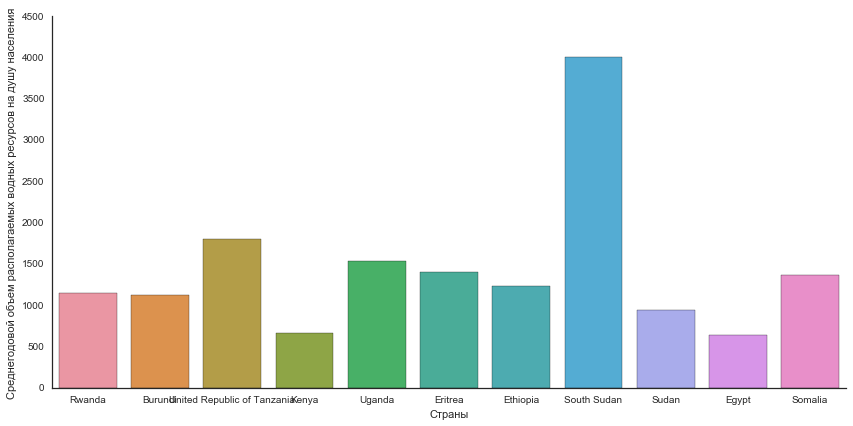

In [144]:
data['Среднегодовой объем располагаемых водных ресурсов на душу населения'] = data['Среднегодовой объем располагаемых водных ресурсов на душу населения'].astype(float)
sns_plot = sns.factorplot(x='Страны', y='Среднегодовой объем располагаемых водных ресурсов на душу населения', data = data[data['Страны'] != 'Democratic Republic of the Congo'], kind="bar", size = 6, aspect = 2)
fig = sns_plot
fig.savefig("output", format = 'png', dpi = 300)
plt.show()

#### (8)

In [685]:
dic['df2013'].loc[countries2, 'Dependency ratio']

Rwanda                              28.57
Burundi                             19.75
United Republic of Tanzania         12.75
Kenya                               32.57
Democratic Republic of the Congo    29.85
Uganda                              35.11
Eritrea                             61.72
Ethiopia                             0.00
South Sudan                         65.79
Sudan                               96.13
Egypt                               96.91
Somalia                             59.18
Name: Dependency ratio, dtype: float64

#### (9)

In [375]:
countries3 = ['Kyrgyzstan', 'Uzbekistan', 'Tajikistan', 'Kazahstan', 'Turkmenistan']

In [376]:
dic['df2013'].loc[countries3, 'Total renewable water resources per capita']

Kyrgyzstan      3976.0
Uzbekistan      1635.0
Tajikistan      2583.0
Kazahstan          NaN
Turkmenistan    4609.0
Name: Total renewable water resources per capita, dtype: float64

#### (10)

In [377]:
df.loc[countries3, 'Agricultural water withdrawal']

Kyrgyzstan      0.010993
Uzbekistan      0.000270
Tajikistan      0.006614
Kazahstan            NaN
Turkmenistan    0.001498
Name: Agricultural water withdrawal, dtype: float64

In [635]:
df.loc[countries2, 'Dependency ratio']

Rwanda                              28.57
Burundi                             19.75
United Republic of Tanzania         12.75
Kenya                               32.57
Democratic Republic of the Congo    29.85
Uganda                              35.11
Eritrea                             61.72
Ethiopia                             0.00
South Sudan                         65.79
Sudan                               96.13
Egypt                               96.91
Somalia                             59.18
Name: Dependency ratio, dtype: float64

#### (11)

In [691]:
# Чисто Нил - это только Египет и Судан
df.loc[countries2, 'Cooperation Index']

Rwanda                              12.1279
Burundi                             15.2369
United Republic of Tanzania         14.1654
Kenya                               12.1279
Democratic Republic of the Congo     21.455
Uganda                              12.1279
Eritrea                               61.72
Ethiopia                            12.1279
South Sudan                           65.79
Sudan                               8.08528
Egypt                               8.08528
Somalia                               59.18
Name: Cooperation Index, dtype: object

In [687]:
df.loc[countries3, 'Cooperation Index']

Kyrgyzstan      15.6568
Uzbekistan      10.9639
Tajikistan      10.9639
Kazahstan           NaN
Turkmenistan    10.9639
Name: Cooperation Index, dtype: object